<a href="https://colab.research.google.com/github/DiabeticRetinopathy114/114_DR/blob/main/224x224%20Gaussian%20Filtered/Resnet50/Resnet50_stage1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sovitrath_diabetic_retinopathy_224x224_gaussian_filtered_path = kagglehub.dataset_download('sovitrath/diabetic-retinopathy-224x224-gaussian-filtered')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/export.pkl
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/f481f76a6b75.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/abdb365cacbc.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/33ffddea8c6e.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/059bc89df7f4.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/278aa860dffd.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/d66b6f333dc7.png
/kaggle/i

In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

2025-06-14 06:22:03.545127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749882123.727421      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749882123.777778      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
!ls -R /kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered | head -n 50


/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered:
gaussian_filtered_images
train.csv

/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images:
gaussian_filtered_images

/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images:
export.pkl
Mild
Moderate
No_DR
Proliferate_DR
Severe

/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild:
0024cdab0c1e.png
00cb6555d108.png
0124dffecf29.png
01b3aed3ed4c.png
0369f3efe69b.png
03e25101e8e8.png
04ac765f91a1.png
059bc89df7f4.png
05a5183c92d0.png
0684311afdfc.png
06b71823f9cd.png
07929d32b5b3.png
07a1c7073982.png
086d41d17da8.png
09935d72892b.png
0a3202889f4d.png
0a61bddab956.png
0ad7f631dedb.png
0d310aba6373.png
0dc031c94225.png
0dce95217626.png
0eb52045349f.png
0f495d87656a.png
0fb1053285cf.png
101b9ebfc720.png
107aea0d9289.png
10f36b0239fb.png
1116271db4ea.png
111898ab463d.png
12ce6a1a1f31.

In [ ]:


# 圖片根目錄（已確認）
image_root = "/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images"

# 讀取 CSV
df = pd.read_csv("/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv")

# 對應診斷分類
diagnosis_classes = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

# 新增 type 欄位（分類資料夾名稱）
df["type"] = df["diagnosis"].map(diagnosis_classes)

# 建立圖片完整路徑
df["image_path"] = df.apply(
    lambda row: os.path.join(image_root, row["type"], f"{row['id_code']}.png"),
    axis=1
)

# 確認圖片是否存在
df["file_exists"] = df["image_path"].apply(os.path.exists)

# 統計結果
missing = df[~df["file_exists"]]
print(f"✅ 成功找到圖片數量：{df['file_exists'].sum()}")
print(f"❌ 找不到圖片數量：{len(missing)}")
print("❌ 範例：", missing["image_path"].head().tolist())


✅ 成功找到圖片數量：3662
❌ 找不到圖片數量：0
❌ 範例： []


In [ ]:
df.head()

,id_code,diagnosis,type,image_path,file_exists
0,000c1434d8d7,2,Moderate,/kaggle/input/diabetic-retinopathy-224x224-gau...,True
1,001639a390f0,4,Proliferate_DR,/kaggle/input/diabetic-retinopathy-224x224-gau...,True
2,0024cdab0c1e,1,Mild,/kaggle/input/diabetic-retinopathy-224x224-gau...,True
3,002c21358ce6,0,No_DR,/kaggle/input/diabetic-retinopathy-224x224-gau...,True
4,005b95c28852,0,No_DR,/kaggle/input/diabetic-retinopathy-224x224-gau...,True


<Axes: ylabel='type'>

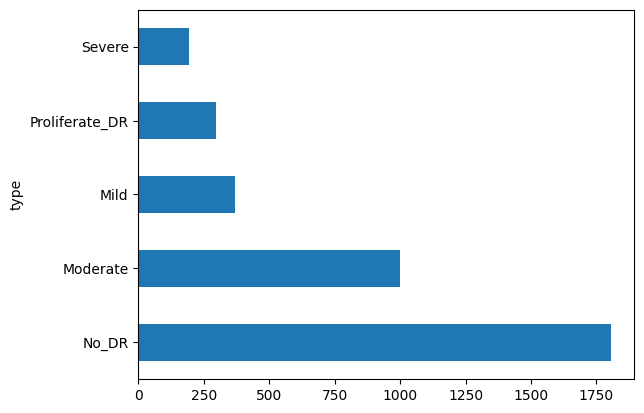

In [ ]:
df['type'].value_counts().plot(kind='barh')

In [ ]:

df['binary'] = df['diagnosis'].apply(lambda x: 'no_DR' if x == 0 else 'DR')
df['str_label'] = df['type'].astype(str)  # 方便分類用

<Axes: ylabel='binary'>

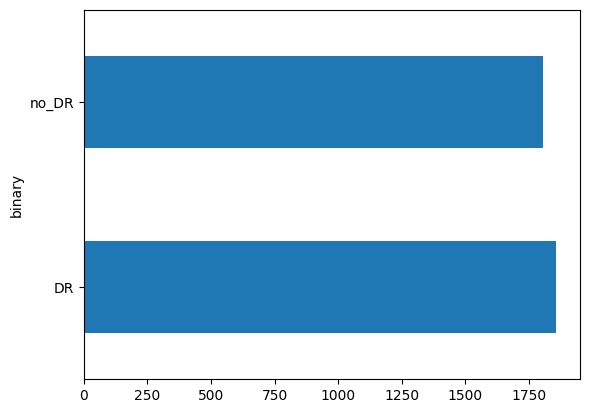

In [ ]:

df['binary'].value_counts().plot(kind='barh')

In [ ]:
# 拆分成兩個資料集
df_stage1 = df.copy()
df_stage2 = df[df['diagnosis'] != 0].copy()
df_stage2['stage2_label'] = df_stage2['diagnosis'] - 1
df_stage2['image_path'] = df_stage2.apply(lambda row: f"{row['type']}/{row['id_code']}.png", axis=1)  # 將 1~4 → 0~3（方便分類）

In [ ]:
# --- Stage 1: 無DR vs 有DR（二元分類） ---
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_dataframe(
    dataframe=df[df["file_exists"]],
    #directory='../input/224x224_GaussianFiltered/gaussian_filtered_images/gaussian_filtered_images',
    x_col='image_path',
    y_col='binary',  # 必須是 'no_DR' / 'DR'
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32,
    subset='training',
    shuffle=True,
    seed=42
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df[df["file_exists"]],
    #directory='../input/224x224_GaussianFiltered/gaussian_filtered_images/gaussian_filtered_images',
    x_col='image_path',
    y_col='binary',  # 必須是 'no_DR' / 'DR'
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32,
    subset='validation',
    shuffle=False,
    seed=42
)

Found 2930 validated image filenames belonging to 2 classes.
Found 732 validated image filenames belonging to 2 classes.


In [ ]:
df[df["file_exists"]]["binary"].value_counts()


binary
DR       1857
no_DR    1805
Name: count, dtype: int64

In [ ]:
import os
import shutil

src_root = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'

diagnosis_dict = {0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}

dst_root = 'train_stage2'
if os.path.exists(dst_root):
    shutil.rmtree(dst_root)
os.makedirs(dst_root)

for _, row in df_stage2.iterrows():
    diagnosis_level = row['diagnosis']  # 整數 0~4
    if diagnosis_level == 0:
        continue  # 跳過 No_DR

    class_folder = str(diagnosis_level - 1)  # 對應 1~4 → 0~3
    filename = row['id_code'] + '.png'  # 你的欄位是 id_code，不是 image
    folder_name = diagnosis_dict[diagnosis_level]

    srcfile = os.path.join(src_root, folder_name, filename)
    dst_dir = os.path.join(dst_root, class_folder)
    os.makedirs(dst_dir, exist_ok=True)

    if os.path.exists(srcfile):
        shutil.copy(srcfile, dst_dir)
    else:
        print(f'❌ 找不到圖片：{srcfile}')


In [ ]:

# --- Stage 2: 多分類（4類） ---

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_stage2_gen = datagen.flow_from_directory(
    'train_stage2',
    target_size=(224, 224),
    class_mode='sparse', #籤輸出為整數類別 ID（例如 0, 1, 2, 3）
    subset='training'
)

val_stage2_gen = datagen.flow_from_directory(
    'train_stage2',
    target_size=(224, 224),
    class_mode='sparse',
    subset='validation'
)

Found 1487 images belonging to 4 classes.
Found 370 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
!pip install imutils
from imutils import paths
from sklearn.utils import shuffle

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [ ]:
def create_resnet_model(output_classes, input_shape=(224, 224, 3), freeze_base=True):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    if freeze_base:
        for layer in base_model.layers[:-20]:
            layer.trainable = False
        for layer in base_model.layers[-20:]:
            layer.trainable = True
    else:
        base_model.trainable = True  # 全部解凍
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    output = Dense(output_classes, activation='softmax' if output_classes > 1 else 'sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)
    for layer in model.layers[-20:]:
        layer.trainable = True
    return model

In [ ]:

# 建立 Stage 1 的模型
model_stage1 = create_resnet_model(output_classes=1, freeze_base=True)
callbacks_stage1 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    #ModelCheckpoint('best_model_stage1.h5', monitor='val_loss', save_best_only=True)
]

model_stage1.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 顯示模型結構
model_stage1.summary()

I0000 00:00:1749882654.582081      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,771,457 (94.50 MB)

 Trainable params: 10,113,537 (38.58 MB)

 Non-trainable params: 14,657,920 (55.92 MB)

In [ ]:
history_stage1 = model_stage1.fit(
    train_gen,
    validation_data=val_gen,
    callbacks=callbacks_stage1,
    epochs=50,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1749882685.027566     127 service.cc:148] XLA service 0x7b78ac004350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749882685.028367     127 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749882687.100562     127 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/92 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.6016 - loss: 0.9512  

I0000 00:00:1749882694.348324     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 107s 899ms/step - accuracy: 0.8061 - loss: 0.5406 - val_accuracy: 0.9536 - val_loss: 0.2997 - learning_rate: 5.0000e-05
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 54s 590ms/step - accuracy: 0.9331 - loss: 0.3170 - val_accuracy: 0.9658 - val_loss: 0.2262 - learning_rate: 5.0000e-05
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 540ms/step - accuracy: 0.9449 - loss: 0.2769 - val_accuracy: 0.9672 - val_loss: 0.2038 - learning_rate: 5.0000e-05
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 469ms/step - accuracy: 0.9507 - loss: 0.2539 - val_accuracy: 0.9686 - val_loss: 0.2239 - learning_rate: 5.0000e-05
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9630 - loss: 0.2234
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 518ms/step - accuracy: 0.9630 - loss: 0.2236 - val_accuracy: 0.9672 - val_loss: 0.2285 - learning_rate: 5.0000e-05
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 498ms/step - accuracy: 0.9642 - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 545ms/step
              precision    recall  f1-score   support

       No_DR       0.98      0.98      0.98       395
          DR       0.97      0.98      0.98       337

    accuracy                           0.98       732
   macro avg       0.98      0.98      0.98       732
weighted avg       0.98      0.98      0.98       732



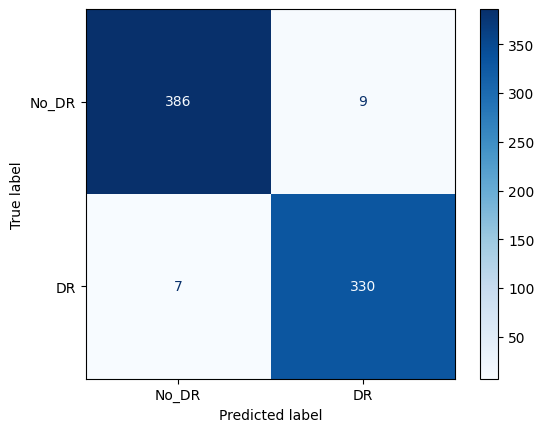

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

# 預測驗證集
val_gen.reset()
y_pred = model_stage1.predict(val_gen, verbose=1)
y_pred_bin = (y_pred > 0.5).astype(int).flatten()  # 二元分類閾值

# 真實標籤
y_true = val_gen.classes

# 混淆矩陣
cm = confusion_matrix(y_true, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No_DR', 'DR'])
disp.plot(cmap='Blues')
# 分類報告
report = classification_report(y_true, y_pred_bin, target_names=['No_DR', 'DR'])
print(report)

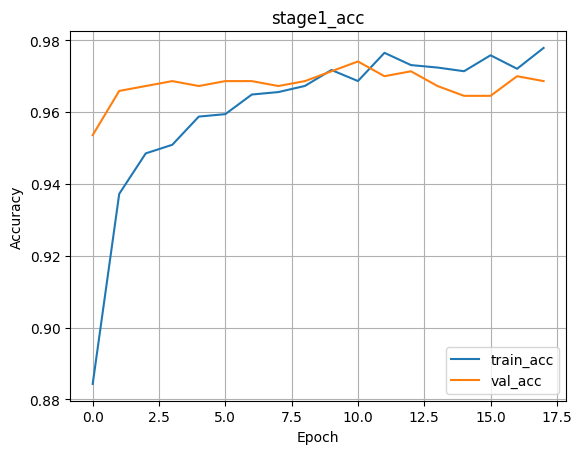

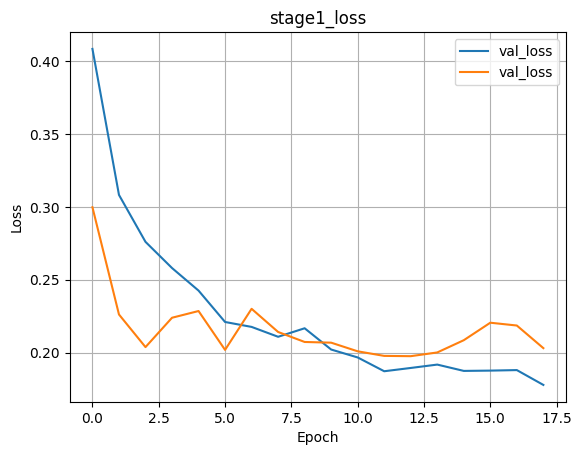

In [ ]:
import matplotlib.pyplot as plt

# 準確率
plt.plot(history_stage1.history['accuracy'], label='train_acc')
plt.plot(history_stage1.history['val_accuracy'], label='val_acc')
plt.title('stage1_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 損失
plt.plot(history_stage1.history['loss'], label='val_loss')
plt.plot(history_stage1.history['val_loss'], label='val_loss')
plt.title('stage1_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
